# Hotel Booking Cancellation Prediction

**Objective:**  
Build a machine learning model to predict whether a customer will cancel their hotel reservation based on historical booking data.  

**Author:** Jesus Alejandro Murillo Perez  
**Date:** 2026-01-02 

---

# Imports and Configuration

In this section, we import all necessary libraries for data manipulation, visualization, preprocessing, model training, and evaluation.

We also configure pandas to display all columns when necessary.

In [1]:
# Standard libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Special encoders
from category_encoders import TargetEncoder

# Visualization
from yellowbrick.model_selection import RFECV as RFECV_viz
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, PrecisionRecallCurve

# Load Dataset

Here we load the hotel booking dataset into a pandas DataFrame.  

We also perform an initial check of the data structure, types, missing values, and statistical summary.


In [2]:
df = pd.read_csv(r'0.f4u5yrlx870.hy81g7kselnhotels.csv')

# Data Exploration and Feature Engineering

We perform exploratory data analysis (EDA) to understand the distribution of numeric and categorical features.  

This includes:
- Checking the distribution of the target variable `is_canceled`
- Observing numeric feature distributions using histograms
- Observing unique values in categorical columns

**Goal:** Identify missing values, outliers, or features that require transformation.

We create new features to help the model:

- Extract `year`, `month`, and `day` from the `reservation_status_date`.
- Create a binary feature `room_assigned_correctly` to indicate whether the assigned room matches the reserved room.
- Remove features that are **causal** or represent future information (`reservation_status`) to prevent data leakage.

Finally, the target variable `is_canceled` shows a slight class imbalance. However, this imbalance is not pronounced, so stratification can be applied during the train/test split without any issues for model training.


In [3]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

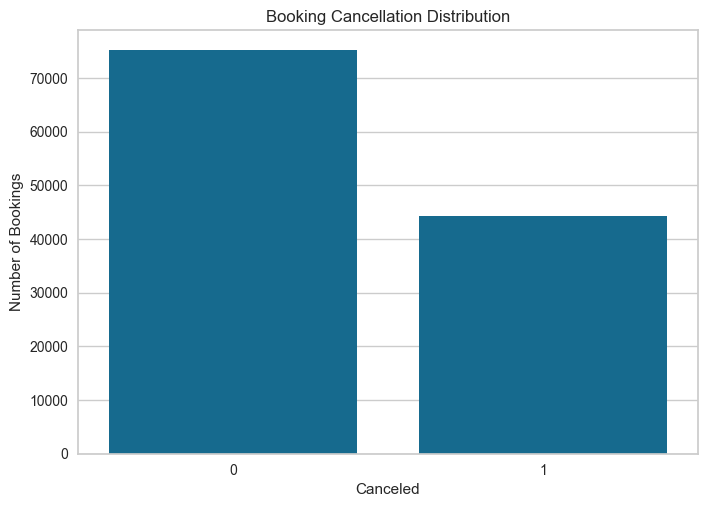

In [6]:
sns.countplot(x='is_canceled', data=df)
plt.title("Booking Cancellation Distribution")
plt.xlabel("Canceled")
plt.ylabel("Number of Bookings")
plt.show()

For column 'hotel', unique values are:
['Resort Hotel' 'City Hotel']

For column 'arrival_date_month', unique values are:
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

For column 'meal', unique values are:
['BB' 'FB' 'HB' 'SC' 'Undefined']

For column 'country', unique values are:
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'B

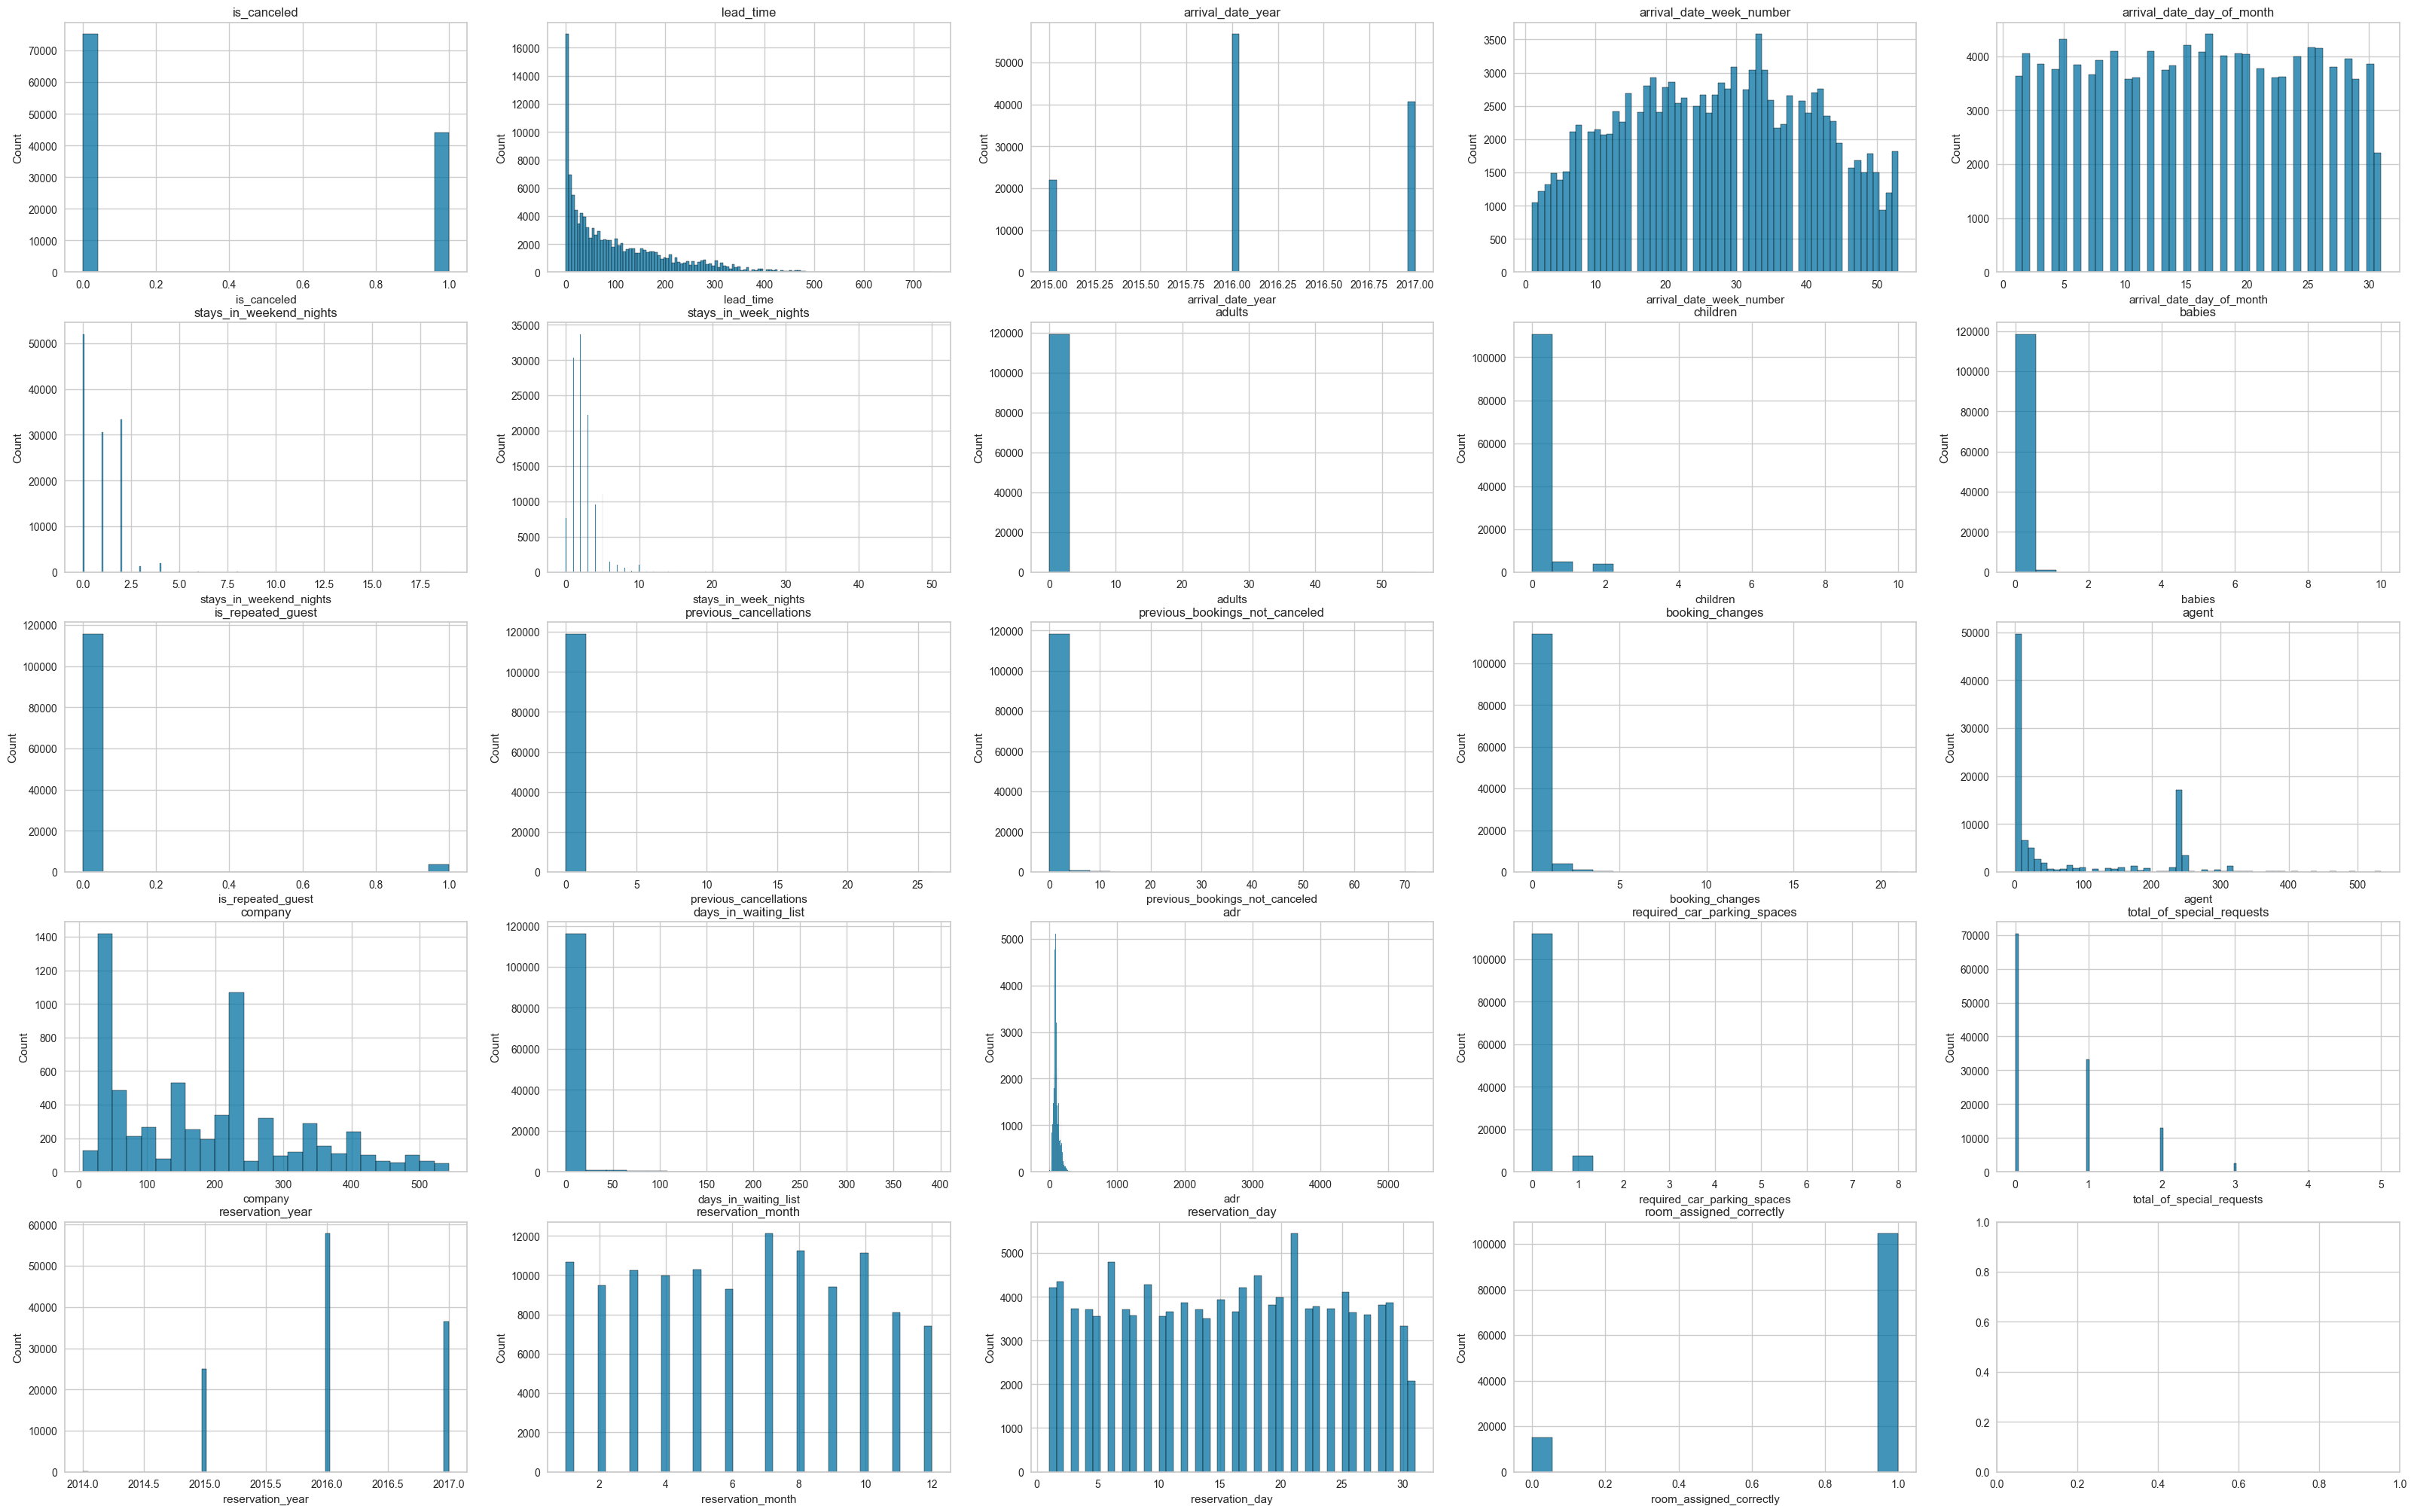

In [7]:
# Initialize lists for categorical and numerical columns
categorical_columns = []
numerical_columns = []

# Convert 'reservation_status_date' to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Extract year, month, and day from reservation status date
df['reservation_year'] = df['reservation_status_date'].dt.year
df['reservation_month'] = df['reservation_status_date'].dt.month
df['reservation_day'] = df['reservation_status_date'].dt.day

# Create a new feature indicating whether the assigned room matches the reserved room
# 1 = assigned room matches reserved room, 0 = otherwise
df['room_assigned_correctly'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)

# Identify categorical and numerical columns
for col in df.columns:
    if df[col].dtype == 'O':  # Object type indicates categorical
        print(f"For column '{col}', unique values are:\n{df[col].unique()}\n")
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

numerical_columns.remove('reservation_status_date')

print('# numerical columns; ', len(numerical_columns))

fig, axes = plt.subplots(5,5, figsize = (40,25))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
  sns.histplot(df[col], ax = axes[i])
  axes[i].set_title(col)

plt.show()

# Data Cleaning

In this step, we handle missing values and inconsistent data.  

- Missing `company`, `agent`, and `children` values are replaced with 0.  
- Missing `country` values are replaced with `'UNKNOWN'`.  
- Ensure proper data types for date columns and numeric features.

Based on the observations from the initial data analysis, missing values were handled according to the nature of each feature:

- For categorical variables, missing values were replaced as appropriate. These categorical features will be encoded using **OneHotEncoder** to convert them into a machine-readable format.  
- The `country` feature, due to its high cardinality, will be encoded using **TargetEncoder** instead of one-hot encoding to avoid creating an excessively sparse feature matrix.

Regarding numerical variables:

- Most of the numeric features are binary or continuous variables that do not require complex transformations.  
- All numeric features will be standardized using **StandardScaler** to ensure consistent scaling across all models.


In [8]:
# Replace missing values safely
df['company'] = df['company'].fillna(0)
df['agent'] = df['agent'].fillna(0)
df['children'] = df['children'].fillna(0)
df['country'] = df['country'].fillna('UNKNOWN')

# Preprocessing Pipelines

We define preprocessing pipelines for:

1. Numeric features: scaled using `StandardScaler`  
2. Categorical features: encoded using `OneHotEncoder`  
3. High-cardinality categorical features (`country`): encoded using `TargetEncoder`

**Purpose:** Standardize the data and convert categorical variables into a machine-readable format.


In [9]:
numerical_columns.remove('is_canceled')
categorical_columns.remove('country')
categorical_columns.remove('reserved_room_type')
categorical_columns.remove('assigned_room_type')

num_transform = Pipeline(steps=[
                                ("scaler", StandardScaler())
                                ]
                         )

cat_transform = Pipeline(steps=[
                               ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
                               ]
                         )

cat_especial_transform = Pipeline(steps=[
                                         ("target_scaler", TargetEncoder())
                                        ]
                                  )

preprocesamiento = ColumnTransformer(
                                     transformers=[
                                                  ("num", num_transform, numerical_columns),
                                                  ("cat", cat_transform, categorical_columns),
                                                  ("tar", cat_especial_transform, 'country'),
                                                  ]
                                     )

# Feature Selection

We use **Recursive Feature Elimination with Cross-Validation (RFECV)** to identify the most important features for prediction.  

- Reduces overfitting  
- Improves model interpretability
- Works well with the preprocessing pipelines defined earlier


In [10]:
model = LogisticRegression(penalty='l2', max_iter = 2000)

rfecv_selector = RFECV(
                       estimator = model,
                       step = 1,
                       cv = 5,
                       scoring = "roc_auc"
                       )

pipeline_rfecv = Pipeline(steps = [
                                   ("preprocesamiento", preprocesamiento),
                                   ("selector", rfecv_selector),
                                  ]
                         )

y = df['is_canceled']
X = df.drop(['is_canceled', 'reserved_room_type', 'assigned_room_type', 'reservation_status_date'], axis=1)

# Train/Test Split

We split the dataset into training and test sets:

- **Test size:** 25%  
- **Stratified by the target variable** to maintain class balance  

This ensures that the model is evaluated fairly on unseen data.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42
                                                   )


pipeline_rfecv.fit(X_train, y_train)


selector_final = pipeline_rfecv.named_steps["selector"]

mask = selector_final.support_
selected_features = mask

print("Número de features seleccionadas:", mask.sum())

pipeline_rfecv.named_steps["preprocesamiento"].get_feature_names_out()[selector_final.support_]

Número de features seleccionadas: 1


array(['cat__reservation_status_Check-Out'], dtype=object)

# Handling Causal Features

During feature analysis, we identified an overlooked issue with the `reservation_status` variable.  

This variable is **causal**, meaning that if a customer has a "check-out" status, they obviously did not cancel their reservation.  
As a result, including this feature in the model would overshadow all other predictors, since it perfectly predicts the target.  

However, this information represents **future data that would not be available at the time of prediction**, making it unsuitable for training a predictive model.  
Therefore, the `reservation_status` feature is **excluded from the dataset** to prevent data leakage and ensure the model's predictions are realistic.


In [12]:
y = df['is_canceled']
X = df.drop(['is_canceled', 'reserved_room_type', 'assigned_room_type', 'reservation_status_date', 'reservation_status'], axis=1)
categorical_columns.remove('reservation_status')

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42
                                                   )

pipeline_rfecv.fit(X_train, y_train)

selector_final = pipeline_rfecv.named_steps["selector"]

mask = selector_final.support_
selected_features = mask

print("Número de features seleccionadas:", mask.sum())

pipeline_rfecv.named_steps["preprocesamiento"].get_feature_names_out()[selector_final.support_]

Número de features seleccionadas: 49


array(['num__lead_time', 'num__arrival_date_year',
       'num__arrival_date_week_number', 'num__arrival_date_day_of_month',
       'num__stays_in_weekend_nights', 'num__stays_in_week_nights',
       'num__is_repeated_guest', 'num__previous_cancellations',
       'num__previous_bookings_not_canceled', 'num__booking_changes',
       'num__agent', 'num__adr', 'num__required_car_parking_spaces',
       'num__total_of_special_requests', 'num__reservation_year',
       'num__reservation_month', 'num__reservation_day',
       'num__room_assigned_correctly', 'cat__hotel_Resort Hotel',
       'cat__arrival_date_month_August',
       'cat__arrival_date_month_December',
       'cat__arrival_date_month_February',
       'cat__arrival_date_month_January', 'cat__arrival_date_month_July',
       'cat__arrival_date_month_June', 'cat__arrival_date_month_March',
       'cat__arrival_date_month_May', 'cat__arrival_date_month_November',
       'cat__arrival_date_month_October',
       'cat__arrival_date_

# Logistic Regression Model

We train a **Logistic Regression model** as our primary model:

- Hyperparameters are tuned using `GridSearchCV`  
- Evaluate performance using **ROC AUC**, **F1 Score**, **Accuracy**, **Precision**, and **Recall**

We also visualize the model using ROC curves, Confusion Matrix, and Precision-Recall curves.


In [13]:
X_train_reduced = pipeline_rfecv.transform(X_train)
X_test_reduced  = pipeline_rfecv.transform(X_test)


pipeline_rl_final = Pipeline(steps = [
                                      ("model", model)
                                     ]
                            )


param_grid_rl = {
              "model__C" : [0.0001, 0.001, 0.01, 0.1, 1, 10],
              "model__penalty" : ["l2"],
              "model__solver" : ["sag", "saga", "newton-cg"]
             }

grid_rl = GridSearchCV(
                       estimator = pipeline_rl_final,
                       param_grid = param_grid_rl,
                       scoring = "roc_auc",
                       cv = 5,
                       n_jobs=-1
                      )

grid_rl.fit(X_train_reduced, y_train)


best_model_rl = grid_rl.best_estimator_
best_model_rl_viz = best_model_rl.named_steps["model"]

best_model_rl_viz

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cg'
,max_iter,2000
,multi_class,'deprecated'


Mejor ROC AUC (CV): 0.9949361657534117


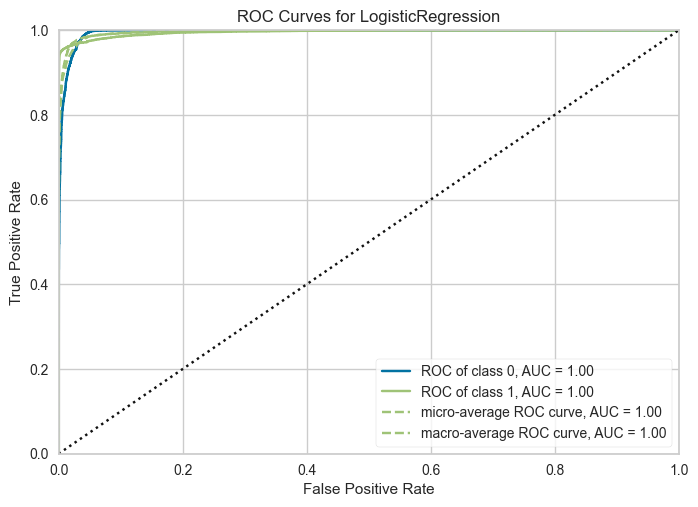

Mejores hiperparámetros: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
ROC AUC en test: 0.9954182481232079
F1 Score: 0.962907455976021
Accuracy: 0.9734655588314125
Precision: 0.9984459984459985
Recall: 0.9298118668596237


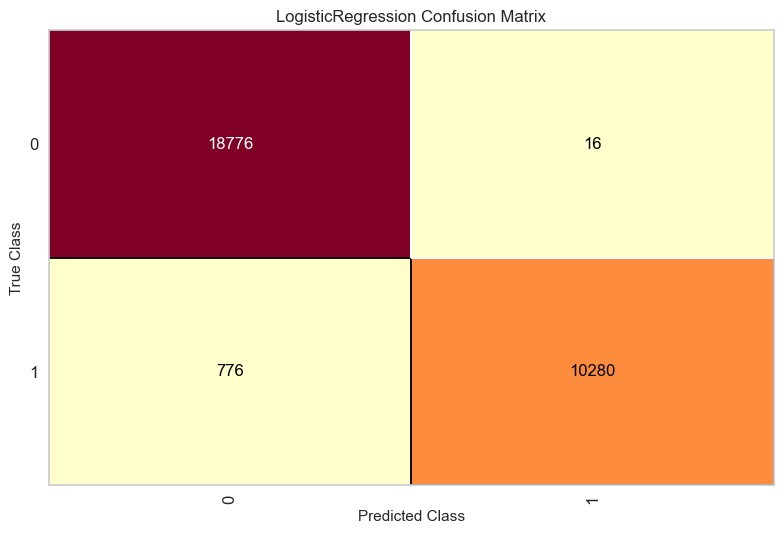

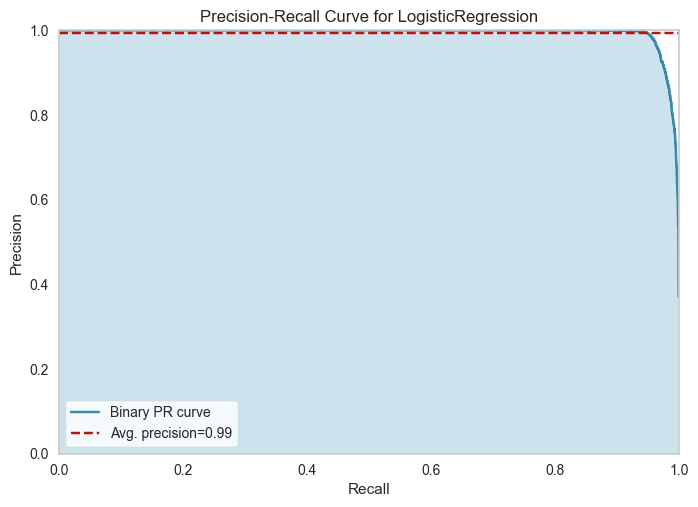

<Axes: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [14]:
modelo_visualizer = LogisticRegression(C=10, max_iter = 2000, solver='newton-cg', penalty = 'l2')

print("Mejor ROC AUC (CV):", grid_rl.best_score_)

roc_vizual = ROCAUC(modelo_visualizer)
roc_vizual.fit(X_train_reduced, y_train)
roc_vizual.score(X_test_reduced, y_test)
roc_vizual.show()

print("Mejores hiperparámetros:", grid_rl.best_params_)
print("ROC AUC en test:", roc_vizual.score(X_test_reduced, y_test))


y_pred = best_model_rl.predict(X_test_reduced)

print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

cm_vizual = ConfusionMatrix(modelo_visualizer)
cm_vizual.fit(X_train_reduced, y_train)
cm_vizual.score(X_test_reduced, y_test)
cm_vizual.show()

pr_vizual = PrecisionRecallCurve(modelo_visualizer)
pr_vizual.fit(X_train_reduced, y_train)
pr_vizual.score(X_test_reduced, y_test)
pr_vizual.show()

In [15]:
resultados_rl = pd.DataFrame(grid_rl.cv_results_)

# Model Evaluation and Interpretation

As observed in the previous evaluation metrics, the Logistic Regression model performs exceptionally well, achieving extremely high scores, all above 0.93.  

The **confusion matrix** indicates that the main type of error occurs when the model predicts that a customer will cancel, but in reality, they do not. Conversely, for customers who do cancel their reservation, the model makes very few errors, capturing almost all actual cancellations. This insight is particularly useful for taking proactive actions, such as targeting customers who are likely to cancel and applying additional retention strategies.

Other evaluation metrics, such as the **Precision-Recall Curve** and **ROC Curve**, are valuable for visualizing how the model maximizes recall while maintaining very high precision. These metrics help understand the trade-off between catching as many cancellations as possible without misclassifying too many non-canceling customers.

Given the outstanding results of the Logistic Regression model, it is challenging to achieve significantly better performance. However, for comparison purposes, a **Random Forest model** was also trained. This choice was motivated by the fact that the Logistic Regression metrics were already extremely high, and Random Forest provides a well-known alternative model that is robust against overfitting, allowing us to validate the stability and reliability of the predictions.



# Random Forest Model (Comparison)

For comparison, we also train a **Random Forest model**:

- Evaluate performance using the same metrics as Logistic Regression
- Compare the number of features used and overall model robustness
- Helps validate that Logistic Regression provides the best balance between performance and simplicity


In [16]:
selector_rf = SelectFromModel(RandomForestClassifier(random_state=42))

pipeline_ranf = Pipeline(steps = [
                                   ("preprocesamiento", preprocesamiento),
                                   ("selector", selector_rf),
                                  ]
                         )


X_train, X_test, y_train, y_test

pipeline_ranf.fit(X_train, y_train)

selector_final_rf = pipeline_ranf.named_steps["selector"]

mask_rf = selector_final_rf.get_support()
selected_features_rf = mask

print("Número de features seleccionadas:", mask_rf.sum())

pipeline_ranf.named_steps["preprocesamiento"].get_feature_names_out()[selector_final_rf.get_support()]

Número de features seleccionadas: 15


array(['num__lead_time', 'num__arrival_date_week_number',
       'num__arrival_date_day_of_month', 'num__stays_in_week_nights',
       'num__previous_cancellations', 'num__agent', 'num__adr',
       'num__required_car_parking_spaces',
       'num__total_of_special_requests', 'num__reservation_month',
       'num__reservation_day', 'num__room_assigned_correctly',
       'cat__market_segment_Online TA', 'cat__deposit_type_Non Refund',
       'tar__country'], dtype=object)

In [17]:
X_train_reduced_rf = pipeline_ranf.transform(X_train)
X_test_reduced_rf  = pipeline_ranf.transform(X_test)

model_rf = RandomForestClassifier(random_state=42)

pipeline_rf_final = Pipeline(steps = [
                                      ("model", model_rf)
                                     ]
                            )


param_grid_rf = {
                 "model__n_estimators": [10, 30, 60, 100, 200],
                 "model__max_depth": [None, 5, 10, 20, 30, 40],
                 "model__class_weight": [None, "balanced"],
                 "model__criterion": ["gini", "entropy"]
                }



grid_rf = GridSearchCV(
                       estimator = pipeline_rf_final,
                       param_grid = param_grid_rf,
                       scoring = "roc_auc",
                       cv = 5,
                       n_jobs=-1
                      )

grid_rf.fit(X_train_reduced_rf, y_train)


best_model_rf = grid_rf.best_estimator_
best_model_rf_viz = best_model_rf.named_steps["model"]

best_model_rf_viz

,n_estimators,200
,criterion,'entropy'
,max_depth,40
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Mejor ROC AUC (CV): 0.9906775250363922


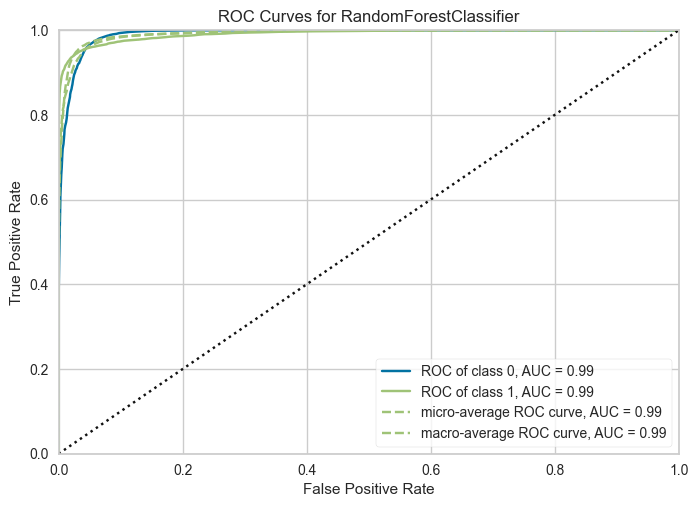

Mejores hiperparámetros: {'model__class_weight': None, 'model__criterion': 'entropy', 'model__max_depth': 40, 'model__n_estimators': 200}
ROC AUC en test: 0.9913241395025179
F1 Score: 0.9466885092440908
Accuracy: 0.9618399892790137
Precision: 0.9809874866621399
Recall: 0.9147069464544139


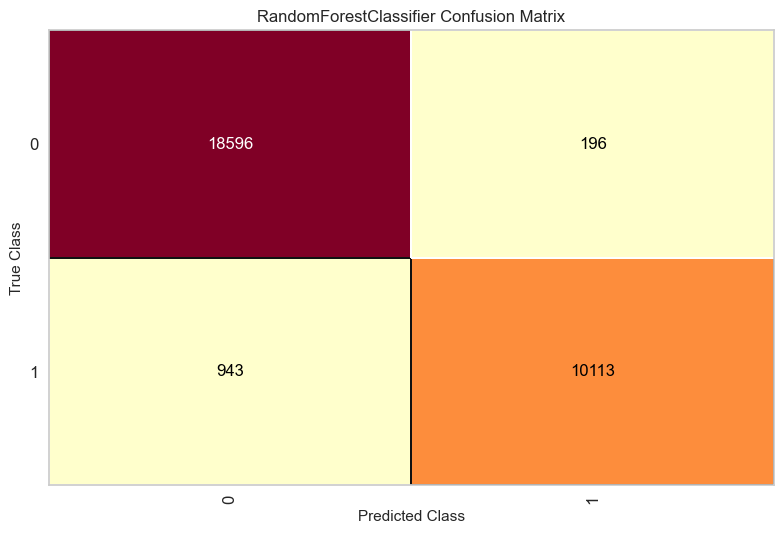

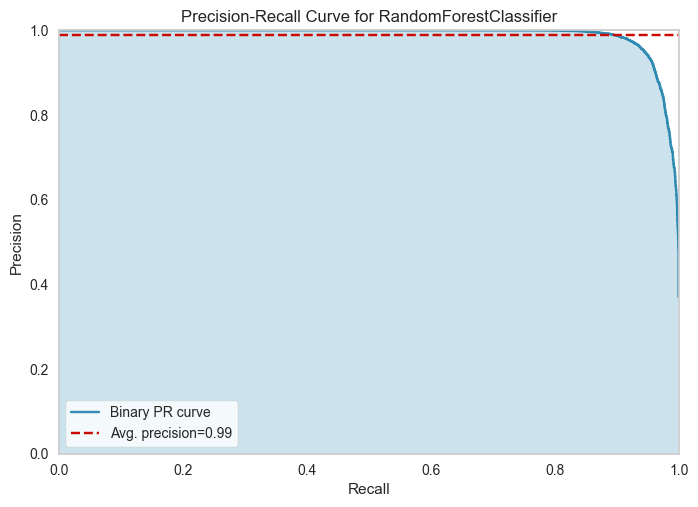

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [18]:
modelo_visualizer = RandomForestClassifier(n_estimators = 200, max_depth = 40, criterion = 'entropy', random_state = 42)

print("Mejor ROC AUC (CV):", grid_rf.best_score_)

roc_vizual = ROCAUC(modelo_visualizer)
roc_vizual.fit(X_train_reduced_rf, y_train)
roc_vizual.score(X_test_reduced_rf, y_test)
roc_vizual.show()

print("Mejores hiperparámetros:", grid_rf.best_params_)
print("ROC AUC en test:", roc_vizual.score(X_test_reduced_rf, y_test))


y_pred = best_model_rf.predict(X_test_reduced_rf)

print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

cm_vizual = ConfusionMatrix(modelo_visualizer)
cm_vizual.fit(X_train_reduced_rf, y_train)
cm_vizual.score(X_test_reduced_rf, y_test)
cm_vizual.show()

pr_vizual = PrecisionRecallCurve(modelo_visualizer)
pr_vizual.fit(X_train_reduced_rf, y_train)
pr_vizual.score(X_test_reduced_rf, y_test)
pr_vizual.show()

In [19]:
resultados_rf = pd.DataFrame(grid_rf.cv_results_)

# Random Forest Comparison and Final Model Selection

Although the Random Forest model achieved slightly lower overall metrics compared to Logistic Regression, it still demonstrated very strong performance. One particular advantage of Random Forest is that it requires **significantly fewer features** than Logistic Regression, which could be a consideration when choosing a simpler or more interpretable model.

However, after evaluating both models, the final decision was to retain the **Logistic Regression model** with the optimal hyperparameters:  
- `C = 10`  
- `penalty = 'l2'`  
- `solver = 'newton-cg'`

This choice was based on its slightly higher performance metrics and robust predictive capabilities.


# Predictions on Full Dataset

Once the final model is selected (Logistic Regression with optimal hyperparameters):

- Predict on the entire dataset  
- Obtain both predicted classes and probabilities  
- Save the predictions into a CSV file for reporting or deployment


In [20]:
y_final_predecido = best_model_rl.predict(pipeline_rfecv.transform(X))
y_proba = best_model_rl.predict_proba(pipeline_rfecv.transform(X))

In [21]:
y_final_predecido

array([0, 0, 0, ..., 0, 0, 0], shape=(119390,))

In [22]:
y_proba

array([[0.96956969, 0.03043031],
       [0.98439247, 0.01560753],
       [0.98939548, 0.01060452],
       ...,
       [0.99439109, 0.00560891],
       [0.98540853, 0.01459147],
       [0.9917896 , 0.0082104 ]], shape=(119390, 2))

In [23]:
df.index

RangeIndex(start=0, stop=119390, step=1)

In [24]:
df_final = pd.DataFrame({
    'Clase' : y_final_predecido,
    'Probabilidades clase 1' : y_proba[:,0],
    'Probabilidades clase 2' : y_proba[:,1]
}, index = df.index)

In [25]:
df_final

,Clase,Probabilidades clase 1,Probabilidades clase 2
0,0,0.969570,0.030430
1,0,0.984392,0.015608
2,0,0.989395,0.010605
3,0,0.986590,0.013410
4,0,0.985260,0.014740
...,...,...,...
119385,0,0.988913,0.011087
119386,0,0.988313,0.011687
119387,0,0.994391,0.005609
119388,0,0.985409,0.014591


In [26]:
df_final.to_csv('Cancel_pred.csv')

In [27]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
